In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
print("Preparing test data..")
market_test_df = pd.read_csv("../data/market_test_df.csv").drop('Unnamed: 0', axis=1)
test_target = market_test_df['returnsOpenNextMktres10']
test_target = test_target.clip(test_target.quantile(0.001), test_target.quantile(0.999))
test_time = market_test_df['time']
market_test_df.drop(['returnsOpenNextMktres10'], axis=1, inplace=True)

Preparing test data..


In [3]:
import model_lgbm_71

/Users/alex/Desktop/Coding/AI/two-sigma-kaggle/env3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
m = model_lgbm_71.model('DecisionTree.model_lgbm_71')


init model DecisionTree.model_lgbm_71


In [5]:
m._load()

[_load] models loaded succesfully


In [6]:
help(m.predict)

Help on method predict in module model_lgbm_71:

predict(X, verbose=False, do_shap=False, normalize=True, normalize_vals=[None]) method of model_lgbm_71.model instance
    given a block of X features gives prediction for everyrow+".pkl"
    
    Args:
        X: [market_train_df, news_train_df]
        shap: perform shap analysis
        normalize: (bool)
        normalize_vals: recommmended self.maxs, self.mins
    Returns:
        y: pandas.Series



In [7]:
import pickle as pk
mins,maxs,rng = pk.load(open("pickle/normalizing.pkl","rb"))

In [8]:
predictions = m.predict([market_test_df, None],verbose=True,normalize=True,normalize_vals=[maxs,mins])

Starting prediction for model DecisionTree.model_lgbm_71, Fri Jan  4 14:58:59 2019
Starting features generation for model DecisionTree.model_lgbm_71, Fri Jan  4 14:58:59 2019
['LGIH.O' 'LGND.O' 'LH.N' ... 'CVGW.O' 'TKC.N' 'TROX.N']
total 2007 df
Finished features generation for model DecisionTree.model_lgbm_71, TIME 67.40037131309509
X_test shape (100000, 48)
Finished prediction for model DecisionTree.model_lgbm_71, TIME 93.68730187416077


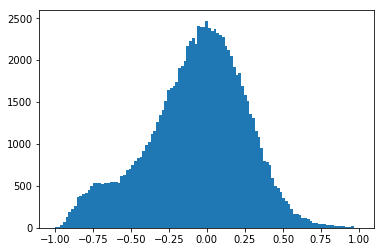

In [9]:
plt.hist(predictions, bins='auto')
plt.show()

In [10]:
from sigma_score import sigma_score

In [11]:
sigma_score(predictions, test_target, test_time)

0.3746138953687197

In [12]:
generated_features = m._generate_features(market_test_df, None,verbose=True,normalize=True,normalize_vals=[maxs,mins])

Starting features generation for model DecisionTree.model_lgbm_71, Fri Jan  4 15:01:58 2019
['LGIH.O' 'LGND.O' 'LH.N' ... 'CVGW.O' 'TKC.N' 'TROX.N']
total 2007 df
Finished features generation for model DecisionTree.model_lgbm_71, TIME 50.80800795555115


In [13]:
import pickle as pk
_ref_models = pk.load(open("pickle/_ref_models.pkl","rb"))

In [14]:
assert type(_ref_models[0]) == type(m.model1)

In [15]:
generated_features.shape

(100000, 48)

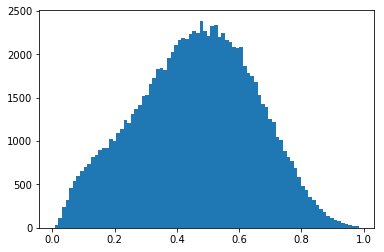

In [16]:
_ref_m1 = _ref_models[0].predict(generated_features.values)
plt.hist(_ref_m1, bins='auto')
plt.show()

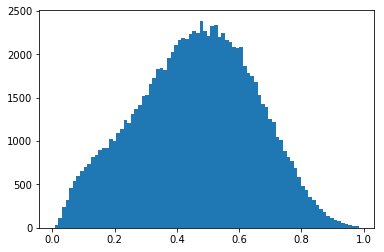

In [17]:
m1 = m.model1.predict(generated_features.values)
plt.hist(m1, bins='auto')
plt.show()

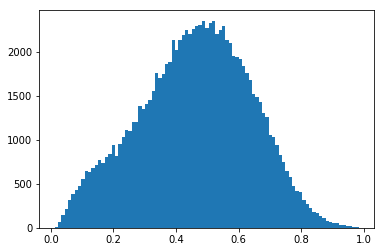

In [18]:
m2 = m.model2.predict(generated_features)
plt.hist(m2, bins='auto')
plt.show()

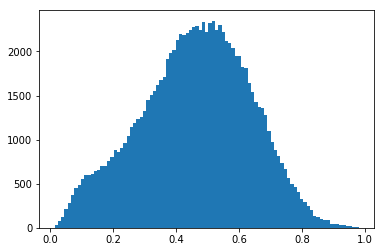

In [19]:
m3 = m.model3.predict(generated_features)
plt.hist(m3, bins='auto')
plt.show()

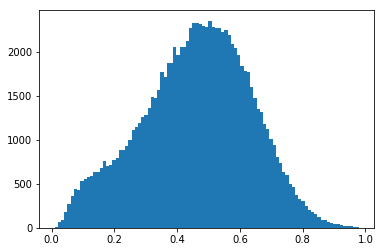

In [20]:
m4 = m.model4.predict(generated_features)
plt.hist(m4, bins='auto')
plt.show()

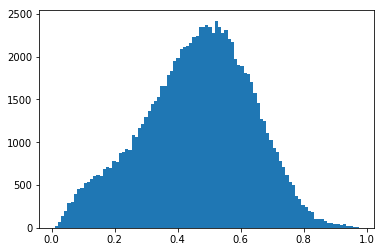

In [21]:
m5 = m.model5.predict(generated_features)
plt.hist(m5, bins='auto')
plt.show()

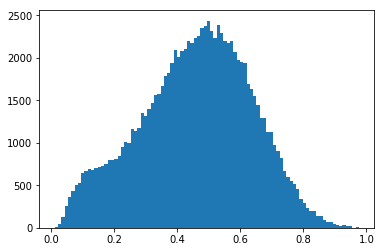

In [22]:
m6 = m.model6.predict(generated_features)
plt.hist(m6, bins='auto')
plt.show()

In [23]:
gbm_1 = _ref_models[0]
gbm_2 = _ref_models[1]
gbm_3 = _ref_models[2]
gbm_4 = _ref_models[3]
gbm_5 = _ref_models[4]
gbm_6 = _ref_models[5]

In [94]:
gbm_1 = m.model1
gbm_2 = m.model2
gbm_3 = m.model3
gbm_4 = m.model4
gbm_5 = m.model5
gbm_6 = m.model6

In [24]:
X_test = generated_features

In [25]:
r_test = test_target

In [26]:
u_test = market_test_df['universe']

In [27]:
d_test = test_time

In [30]:
#实现零均值归一化操作
confidence_test = (gbm_1.predict(X_test) + gbm_2.predict(X_test)+gbm_3.predict(X_test)+gbm_4.predict(X_test)+gbm_5.predict(X_test)+gbm_6.predict(X_test))/6
confidence_test = (confidence_test-confidence_test.min())/(confidence_test.max()-confidence_test.min())
#print("max_min",max_min)
#confidence_test=(confidence_test-confidence_test.mean())/(confidence_test.std())
confidence_test = confidence_test*2-1
print(max(confidence_test),min(confidence_test))

# calculation of actual metric that is used to calculate final score
r_test = r_test.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_test * r_test * u_test
data = {'day' : d_test, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_test = mean / std
print(score_test)

1.0 -1.0
0.30394858476774617


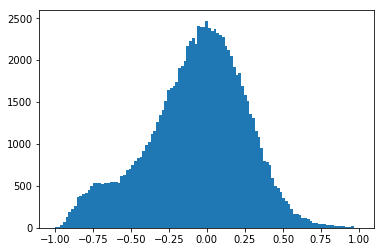

In [31]:
plt.hist(confidence_test,bins='auto')
plt.show()